In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ——————————————————————————
# 1. DEFINITION OF WORKSPACE 
# ——————————————————————————
xmin, xmax, ymin, ymax, res = 0.0, 10.0, 0.0, 10.0, 0.05
q_start = np.array([1.0, 1.0])
q_goal  = np.array([9.0, 9.0])

# Circular obstacle: (x, y, radius)
obstacles = [
    (4.5, 2.0, 1.5),
    (3.0, 7.0, 1.8),
    (8.0, 6.0, 1.6)
]

# Field parameters
k_att = 1.0     # scaling factor of attractive potential
k_rep = 5.0     # scaling factor of repulsive potential
d0 = 1.0        # range of influence of obstacle

In [2]:
# ——————————————————————————
# 2. POTENTIAL FIELD – FORCE FUNCTIONS
# ——————————————————————————
def P_att(q):
    """Attractive potential"""
    return 0.5 * k_att * np.sum((q - q_goal) ** 2)

def P_rep(q):
    """Repulsive potential"""
    P = 0.0
    for (cx, cy, r) in obstacles:
        d = np.linalg.norm(q - np.array([cx, cy])) - r  # the shortest distance from the current to the obtacle
        if d <= 0:      # inside obstacle → infinity
            return np.inf 
        if d <= d0:     # in the range of influence
            P = 0.5 * k_rep * (1/d - 1/d0)**2
    return P

def P_total(q):
    return P_att(q) + P_rep(q)

def F_total(q):
    """Gradient of P → force = -∇P."""
    # Attractive force
    F_att = -k_att * (q - q_goal)

    # Repulsive force   
    F_rep = np.zeros(2)
    for (cx, cy, r) in obstacles:
        vec = q - np.array([cx, cy])
        dist = np.linalg.norm(vec)
        d  = dist - r
        if 0 < d <= d0:
            grad_d = vec / dist     # gradient for circular obstacles
            F_rep += k_rep * (1/d - 1/d0) * (1/d**2) * grad_d
    return F_att + F_rep

In [3]:
# ——————————————————————————
# 3. PATH SIMULATION
# ——————————————————————————
step_size  = 0.05   # step size for each iteration
goal_tol   = 0.15   # threshold considered to be reached
max_iters  = 1000

q = q_start.copy()
path = [q.copy()]

for _ in range(max_iters):
    F = F_total(q)
    if np.any(np.isinf(F)) or np.isnan(F).any():
        print("Robot hits obstacle / infinite potential energy – stops.")
        break
    q = q + step_size * F / (np.linalg.norm(F) + 1e-9)  # update current location
    path.append(q.copy())
    if np.linalg.norm(q - q_goal) < goal_tol:
        print("Reached the goal after", len(path)-1, "steps.")
        break
else:
    print("Run out of loops but not yet reached the goal.")

path = np.array(path)

Reached the goal after 237 steps.


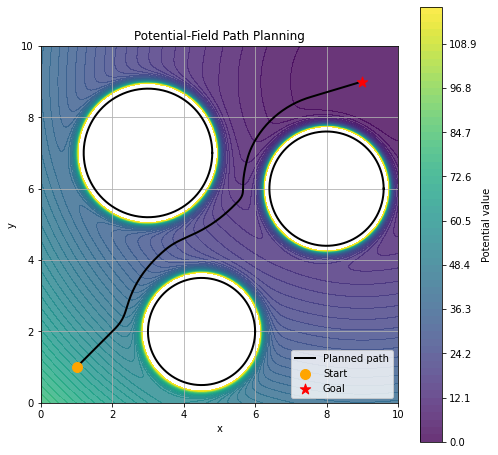

In [4]:
# ——————————————————————————
# 4. VISUALIZATION
# ——————————————————————————
# 4.1 Potential field (contour)
xs = np.arange(xmin, xmax + res, res)
ys = np.arange(ymin, ymax + res, res)
X, Y = np.meshgrid(xs, ys)
P = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        P[i, j] = P_total(np.array([X[i, j], Y[i, j]]))

plt.figure(figsize=(8, 8))
levels = np.linspace(np.nanmin(P[P < np.inf]), np.nanpercentile(P[P < np.inf], 94), 60) # define contour levels
plt.contourf(X, Y, P, levels=levels, cmap="viridis", alpha=0.8) # contour plot
plt.colorbar(label="Potential value")                           # color bar

# 4.2 Obtacles
phi = np.linspace(0, 2*np.pi, 100)
for (cx, cy, r) in obstacles:
    plt.plot(cx + r*np.cos(phi), cy + r*np.sin(phi), "k", lw=2)

# 4.3 Path and start/goal points
plt.plot(path[:,0], path[:,1], c="black", lw=2, label="Planned path")
plt.scatter(*q_start, c="orange", s=100, zorder=5, label="Start")
plt.scatter(*q_goal,  c="red",   s=120, marker="*", zorder=5, label="Goal")

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.gca().set_aspect("equal")
plt.grid(True)
plt.title("Potential-Field Path Planning")
plt.xlabel("x"), plt.ylabel("y")
plt.legend()
plt.show()